In [1]:
from bs4 import BeautifulSoup
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import geopandas as gpd
import shapely
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon


pd.options.display.max_rows = 999
pd.set_option('display.max_rows', 200)

# file_path = '/Users/j5/Documents/repo/covid/'
# file_path = '/Users/J3/Downloads/repo/covid/'

# output_file_path = '/Users/J3/Downloads/repo/covid/output_files/'
# input_file_path = '/Users/J3/Downloads/repo/covid/input_files/'
# file_path_shp = '/Users/J3/Downloads/repo/covid/la-county-regions-current/'


output_file_path = '/Users/j6/Documents/repo/covid/output_files/'
input_file_path = '/Users/j6/Documents/repo/covid/input_files/'
file_path_shp = '/Users/j6/Documents/repo/covid/la-county-regions-current/'

In [2]:
column_names = ['u', 'ds']
ul = pd.read_csv(input_file_path+"url_list.csv"
                 , skiprows = 1
                 , names = column_names
                )

In [3]:
appended_data_list_h = []

for i, row in ul[ul['ds'] >= '2020-03-21'].iterrows():
    print(row['u'])
    url = row['u']
    reqs = requests.get(url)
    soup = BeautifulSoup(reqs.text, 'lxml')
    soup.find_all("li")
    l = []
    
    for tag in soup.find_all("li"):
        l.append(tag.text)

    dfh=pd.DataFrame(l, columns = ["name"])

    dfh=dfh[dfh['name'].str.contains("Hospital")]
    dfh=dfh[~dfh['name'].str.contains("Avoid")]
    dfh[['A','B']]=dfh.name.apply(lambda x: pd.Series(str(x).split("\t"))) 
    dfh[["B"]] = dfh[["B"]].apply(pd.to_numeric, errors = 'coerce', axis = 1)
    dfh=dfh[['A','B']]
    dfh['ds'] = pd.to_datetime(row['ds'])
    appended_data_list_h.append(dfh)

dfh_final = pd.concat(appended_data_list_h)
dfh_final=dfh_final.sort_values(["B"])
dfh_final["new_hospitalizations"]=dfh_final["B"].diff()
dfh_final["new_hospitalizations_rolling_7d_mean"] = dfh_final["new_hospitalizations"].rolling(7).mean().round(0)
print(dfh_final)
dfh_final.to_csv(output_file_path+'covid_final_hospital.csv')
# dfh_final.to_csv('/Users/J5/Downloads/covid_final_hospital.csv')
# dfh_final.to_csv('/Users/J5/Downloads/covid_final_hospital_b.csv')

http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2381&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2380&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2377&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2375&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2373&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2370
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cur=cur&prid=2369&row=25&start=1
http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&ou=ph&prog=media&cu

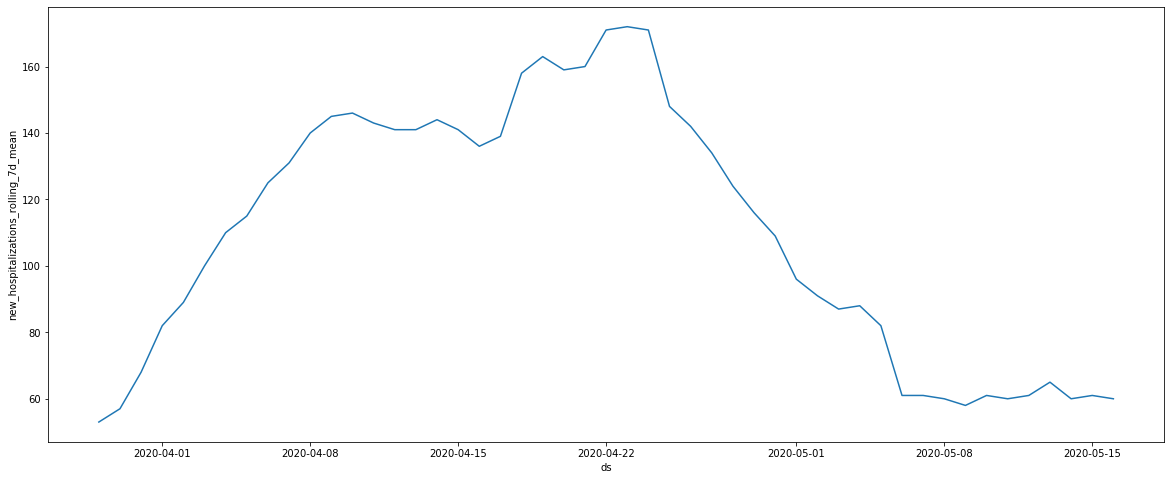

In [4]:
plt.figure(figsize=(20,8))
sns.lineplot(data=dfh_final, x='ds', y='new_hospitalizations_rolling_7d_mean')

In [5]:
df_ct = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')
df_ct = df_ct[df_ct["county"] == "Los Angeles"]
df_ct = df_ct.sort_values(["date"])
df_ct["new_cases"] = df_ct["cases"].diff()
df_ct["new_deaths"] = df_ct["deaths"].diff()

df_ct["ds"] = pd.to_datetime(df_ct['date'])
df_ct["dow"]=df_ct["ds"].dt.dayofweek
df_ct["week_of_year"]=df_ct["ds"].dt.week


df_ct = pd.merge(df_ct, dfh_final[["B","ds"]], how = 'left', on = 'ds' )
df_ct["B"] = pd.to_numeric(df_ct["B"], errors='coerce')

df_ct["deaths_7d_avg"] = df_ct["new_deaths"].rolling(7).mean().round(0)
df_ct["new_hospitalizations"] = df_ct["B"].diff()
df_ct["hospitalizations_7d_avg"] = df_ct["new_hospitalizations"].rolling(7).mean().round(0)
df_ct["new_cases_7d_avg"] = df_ct["new_cases"].rolling(7).mean().round(0)
print(df_ct)
# df_ct.to_csv('/Users/J5/Downloads/df_ct.csv')
df_ct.to_csv(output_file_path+'df_ct.csv')

           date       county       state    fips  cases  deaths  new_cases  \
0    2020-01-26  Los Angeles  California  6037.0      1       0        NaN   
1    2020-01-27  Los Angeles  California  6037.0      1       0        0.0   
2    2020-01-28  Los Angeles  California  6037.0      1       0        0.0   
3    2020-01-29  Los Angeles  California  6037.0      1       0        0.0   
4    2020-01-30  Los Angeles  California  6037.0      1       0        0.0   
5    2020-01-31  Los Angeles  California  6037.0      1       0        0.0   
6    2020-02-01  Los Angeles  California  6037.0      1       0        0.0   
7    2020-02-02  Los Angeles  California  6037.0      1       0        0.0   
8    2020-02-03  Los Angeles  California  6037.0      1       0        0.0   
9    2020-02-04  Los Angeles  California  6037.0      1       0        0.0   
10   2020-02-05  Los Angeles  California  6037.0      1       0        0.0   
11   2020-02-06  Los Angeles  California  6037.0      1       0 

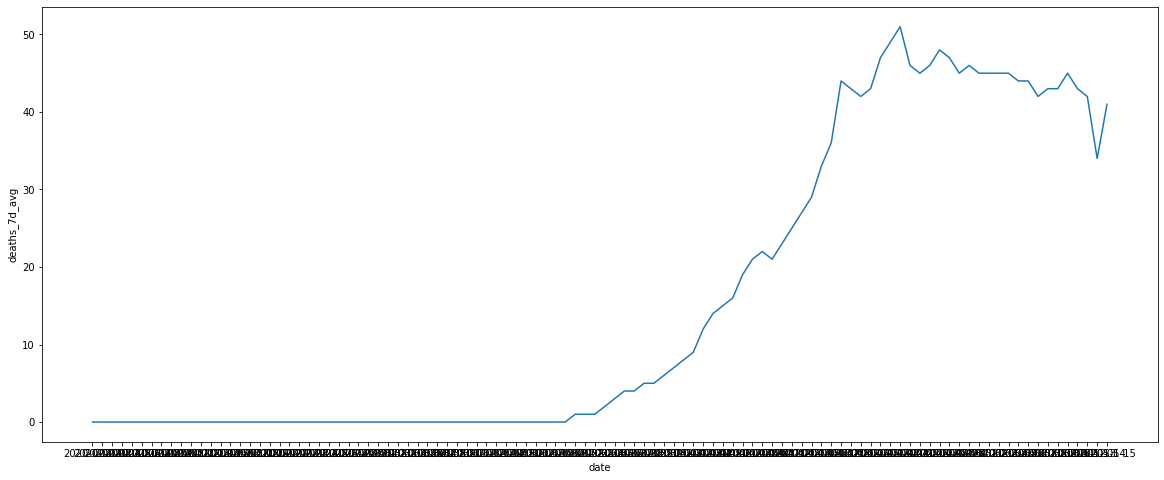

In [6]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df_ct, x='date', y='deaths_7d_avg')

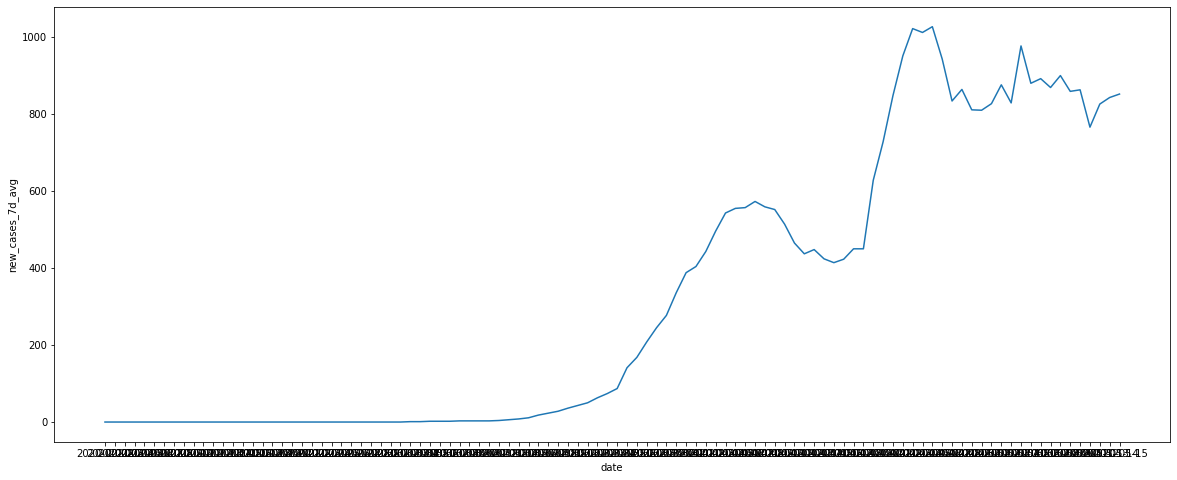

In [7]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df_ct, x='date', y='new_cases_7d_avg')